In [12]:
import sys
sys.path.append("/alpha-graph")
import project
import pytorch_lightning as pl
from codecarbon import track_emissions
from project.modules.networks.network_lightning import MainNet
from project.modules.data_modules.data_classes import DataModule, ExpTrajDataSet
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from project.modules.networks.callbacks import LatentSpaceSaver
from torch_geometric.data import DataLoader
import logging
import torch
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import scipy.stats as st
import importlib
import umap
from sklearn.preprocessing import StandardScaler
importlib.reload(umap)

<module 'umap' from '/usr/local/lib/python3.8/dist-packages/umap/__init__.py'>

In [13]:
def setup(tasks,ds_params,net_params, dl_params, graph_info):
    pl.seed_everything(1234)
    dm = DataModule(ds_params=ds_params,
                    dl_params=dl_params,
                    graph_info=graph_info)
    dm.setup()
    model = MainNet(tasks=tasks,
                    latent_dim=net_params["latent_dim"],
                    n_c = net_params["n_c"],
                    dm = dm)
    
    return model, dm

In [14]:
ds_params = {"dim":2,
        "RW_types":["sBM","CTRW","fBM","LW","OU","BM"],
        "N":int(1e5),
        "length_range":(10,150),
        "noise_range":(0.1,0.4), # Issues when noise is too low
        "drift_range":(0.,0.5)}

net_params = {"latent_dim":32,
                "n_c":32}

dl_params = {"batch_size":128,"num_workers":10}

graph_info = {"edges_per_point":20,
                "clip_trajs":True,
                "scale_types":["step_std","step_mean","pos_std"],
                "log_features":True,
                "edge_method":"geom_causal"}

tasks = ["model","drift_norm","alpha"]

Global seed set to 1234
INFO:lightning:Global seed set to 1234


stage is None, strange...
f size =  [50, 128, 64, 32]
Convolution has 17462 parameters. Input dim is 25, output is 32
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
f size =  [128, 128, 64, 32]
Convolution has 27680 parameters. Input dim is 64, output is 32
alpha MLP size =  [32, 128, 128, 64, 16, 1]
Alpha predictor has 30723 parameters


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Metric `ExplainedVariance` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


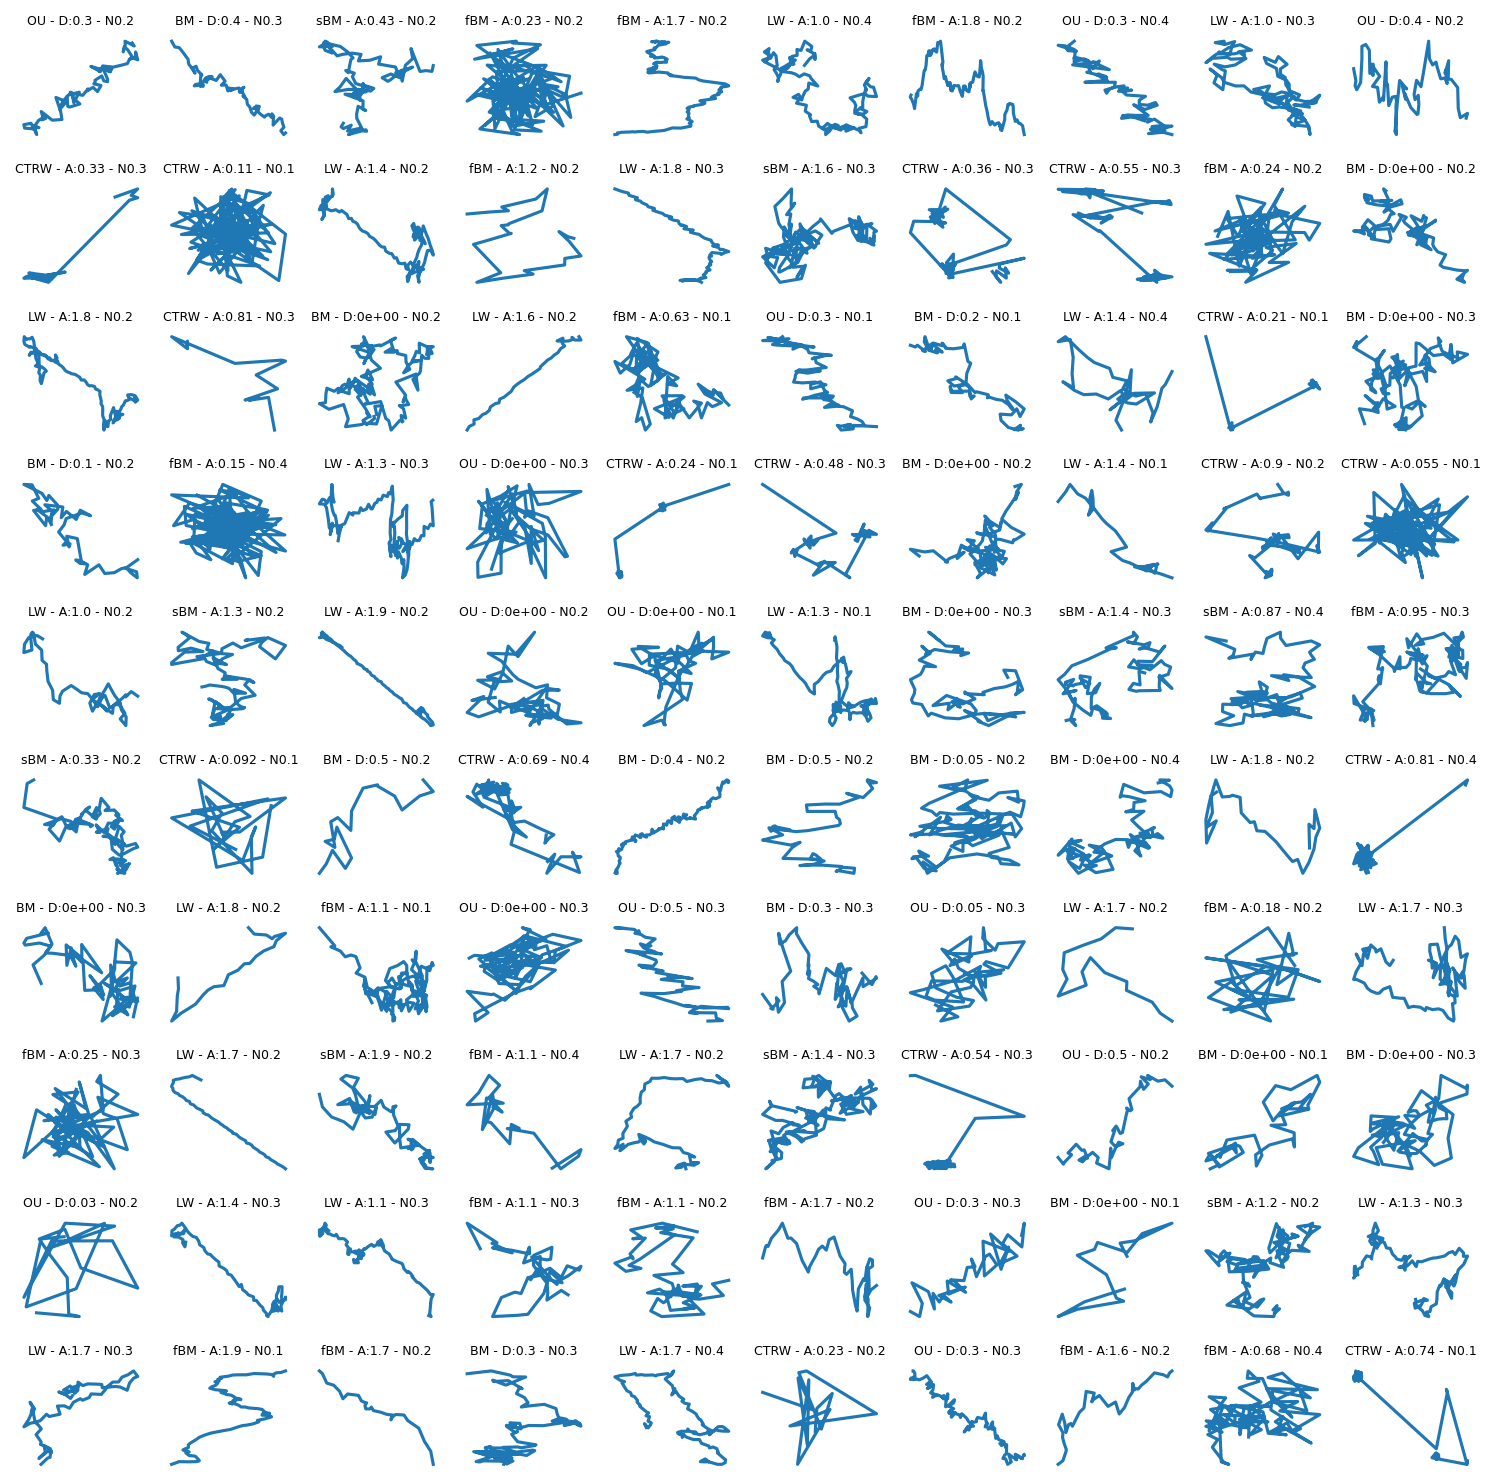

In [15]:
model, dm = setup(tasks, ds_params, net_params, dl_params, graph_info)

In [17]:
model = MainNet.load_from_checkpoint("/gaia/models/unsupervised_v1-v41.ckpt",dm=dm)

f size =  [50, 128, 64, 32]
Convolution has 17462 parameters. Input dim is 25, output is 32
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
f size =  [128, 128, 64, 32]
Convolution has 27680 parameters. Input dim is 64, output is 32
alpha MLP size =  [32, 128, 128, 64, 16, 1]
Alpha predictor has 30723 parameters


In [20]:
del h

In [21]:
out = []
h = []
true_model = []
drift_norm = []
length = []
alpha = []
for i, batch in enumerate(tqdm(dm.test_dataloader(no_parallel=True))):
    _ = model(batch)
    true_model.append(batch.model)
    drift_norm.append(batch.drift_norm)
    length.append(batch.length)
    alpha.append(batch.alpha)
    out.append(_[0])
    if i <= 100:
        h.append(_[1])

  0%|          | 0/782 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 239, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.8/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/local/lib/python3.8/dist-packages/torch/multiprocessing/reductions.py", line 321, in reduce_storage
    fd, size = storage._share_fd_()
RuntimeError: unable to write to file </torch_24208_3874116973>
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 239, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.8/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/local/lib/python3.8/dist-packages/torch/multiprocessing/reductions.py", line 321, in reduce_storage
    fd, size = storage._share_fd_()
RuntimeError: unable to write to file </torch_24209_4097161738>


RuntimeError: DataLoader worker (pid 24209) is killed by signal: Killed. 

In [22]:
pred_model = np.concatenate([o["model"].detach().cpu().numpy() for o in out],axis=0)
pred_DN = np.concatenate([o["drift_norm"][:,0].detach().cpu().numpy() for o in out],axis=0)
pred_alpha = np.concatenate([o["alpha"][:,0].detach().cpu().numpy() for o in out],axis=0)
true_model = np.concatenate([d[:,0].detach().cpu().numpy() for d in true_model], axis=0)
true_D = np.concatenate([d[:,0].detach().cpu().numpy() for d in drift_norm], axis=0)
true_alpha = np.concatenate([d[:,0].detach().cpu().numpy() for d in alpha], axis=0)

scaler = StandardScaler()
H = np.concatenate([H.detach().cpu().numpy() for H in h],axis=0)
H = scaler.fit_transform(H)

In [23]:
PUMA = umap.ParametricUMAP(verbose=True,min_dist=0.5,n_training_epochs=1)

In [24]:
PUMA.fit(H)
X = PUMA.transform(H)

ParametricUMAP(optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4ae29f4250>)
Construct fuzzy simplicial set
Mon Mar 15 13:59:28 2021 Finding Nearest Neighbors
Mon Mar 15 13:59:28 2021 Building RP forest with 11 trees
Mon Mar 15 13:59:29 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Mar 15 13:59:45 2021 Finished Nearest Neighbor Search
Mon Mar 15 13:59:48 2021 Construct embedding


/usr/local/lib/python3.8/dist-packages/umap/parametric_umap.py:269: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/10
151/151 [==============================] - 3s 11ms/step - loss: 0.6051
Epoch 2/10
151/151 [==============================] - 2s 12ms/step - loss: 0.1552
Epoch 3/10
151/151 [==============================] - 2s 12ms/step - loss: 0.1461
Epoch 4/10
151/151 [==============================] - 2s 12ms/step - loss: 0.1418
Epoch 5/10
151/151 [==============================] - 2s 12ms/step - loss: 0.1385
Epoch 6/10
151/151 [==============================] - 2s 12ms/step - loss: 0.1385
Epoch 7/10
151/151 [==============================] - 2s 12ms/step - loss: 0.1357
Epoch 8/10
151/151 [==============================] - 2s 12ms/step - loss: 0.1342
Epoch 9/10
151/151 [==============================] - 2s 12ms/step - loss: 0.1333
Epoch 10/10
404/404 [==============================] - 0s 806us/step
Mon Mar 15 14:00:08 2021 Finished embedding
13/13 [==============================] - 0s 2ms/step


In [26]:
N_H = H.shape[0]

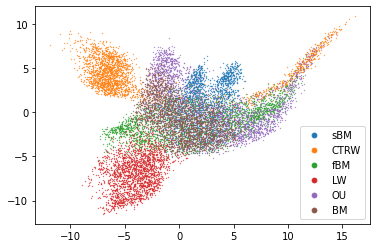

In [37]:
for m in np.unique(true_model):
    c = true_model[:N_H] == m
    plt.scatter(X[c,0],X[c,1],s=.1,label=model.hparams["RW_types"][m])
    plt.legend(markerscale=15)

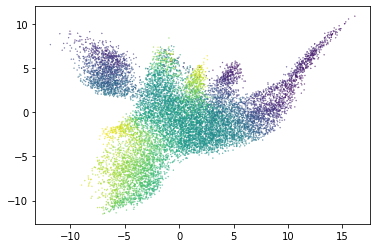

In [42]:
c = true_model[:N_H] < 10
plt.scatter(X[c,0],X[c,1],s=.1,c=pred_alpha[:N_H][c])

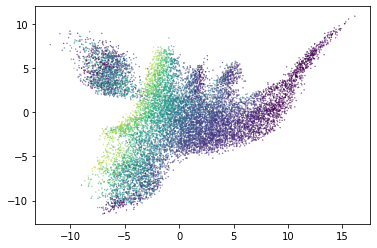

In [43]:
c = true_model[:N_H] < 10
plt.scatter(X[c,0],X[c,1],s=.1,c=pred_DN[:N_H][c])

In [51]:
length = np.concatenate([l[:,0].detach().cpu().numpy() for l in length],axis=0)

In [88]:
from sklearn.metrics import f1_score

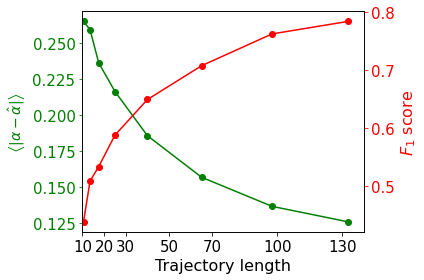

In [118]:
c = true_alpha > 0.
error = np.abs(pred_alpha-true_alpha)[c]
l_bins = np.array([9,12,15,20,30,50,80,115,150])
l_bins_center = .5*(l_bins[1:] + l_bins[:-1])
l_labels = np.digitize(length[c],l_bins)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(l_bins_center,[np.mean(error[l_labels == i]) for i in range(1,len(l_bins))],"-o",c="green")
#ax1.set_xscale("log")
ax1.set_xlim((10,140))
ax1.set_xticks([10,20,30,50,70,100,130])
ax1.set_xticklabels([10,20,30,50,70,100,130])
ax1.tick_params(axis='y', colors='green')
ax1.set_ylabel("$\left \langle | \\alpha - \hat{\\alpha} | \\right \\rangle$",fontsize=14,c="green")
ax1.set_xlabel("Trajectory length",fontsize=16)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)


l_labels = np.digitize(length,l_bins)
ax2 = ax1.twinx()
ax2.plot(l_bins_center,[f1_score(np.argmax(pred_model[l_labels == i],axis=1),
                                 true_model[l_labels == i],average="micro") for i in range(1,len(l_bins))],
         "-o",c="red")
ax2.set_ylabel("$F_1$ score",fontsize=16,c="red")
ax2.tick_params(axis='y', colors='red',labelsize=15)
plt.tight_layout()
plt.savefig("/gaia/figures/imagingviruses/perf.pdf")